In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# National model

In [2]:
"""
This script contains a calibration of national COVID-19 SEIQRD model to hospitalization data in Belgium.
"""

__author__      = "Tijs Alleman"
__copyright__   = "Copyright (c) 2021 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved."

############################
## Load required packages ##
############################

import os
import sys
import ast
import click
import json
import pickle
import emcee
import datetime
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19model.data import sciensano
from covid19model.optimization.objective_fcns import log_prior_uniform, ll_poisson, ll_negative_binomial, log_posterior_probability
from covid19model.optimization.utils import perturbate_PSO, run_MCMC, assign_PSO
from covid19model.visualization.optimization import plot_PSO

#############################
## Handle script arguments ##
#############################

identifier = 'tryout_automatic_alignment'
n_pso = 10
n_mcmc = 10
n_age_groups = 10
age_stratification_size=n_age_groups
start_calibration = pd.to_datetime('2020-03-15')
end_calibration = pd.to_datetime('2021-10-01')
high_performance_computing=True
backend=None
run_date = str(datetime.date.today())

##############################
## Define results locations ##
##############################

# Path where traceplot and autocorrelation figures should be stored.
# This directory is split up further into autocorrelation, traceplots
fig_path = f'../../results/calibrations/COVID19_SEIQRD/national/'
# Path where MCMC samples should be saved
samples_path = f'../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/national/'
# Path where samples backend should be stored
backend_folder = f'../../results/calibrations/COVID19_SEIQRD/national/national/'
# Verify that the paths exist and if not, generate them
for directory in [fig_path, samples_path, backend_folder]:
    if not os.path.exists(directory):
        os.makedirs(directory)
# Verify that the fig_path subdirectories used in the code exist
for directory in [fig_path+"autocorrelation/", fig_path+"traceplots/", fig_path+"pso/"]:
    if not os.path.exists(directory):
        os.makedirs(directory)

##################################################
## Load data not needed to initialize the model ##
##################################################

# Sciensano hospital and vaccination data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, update_data=False)

#from covid19model.data import model_parameters
#age_classes=pd.IntervalIndex.from_tuples([(0, 12), (12, 18), (18, 25), (25, 35), (35, 45), (45, 55), (55, 65), (65, 75), (75, 85), (85, 120)], closed='left')
#Nc_dict, params, samples_dict, initN = model_parameters.get_COVID19_SEIQRD_parameters(age_classes=age_classes)

#def compute_RO_COVID19_SEIQRD(beta, a, da, omega, Nc, initN):
#    R0_i = beta*(a*da+omega)*np.sum(Nc,axis=1)
#    return sum((R0_i*initN)/sum(initN))

#print(compute_RO_COVID19_SEIQRD(0.027, model.parameters['a'], model.parameters['da'], model.parameters['omega'], Nc_dict['total'], initN))

model.parameters['beta'] = 0.027 # R0 = 3.31 --> https://pubmed.ncbi.nlm.nih.gov/32498136/
warmup = 39 # Start 5 Feb. 2020: day of first detected COVID-19 infectee in Belgium

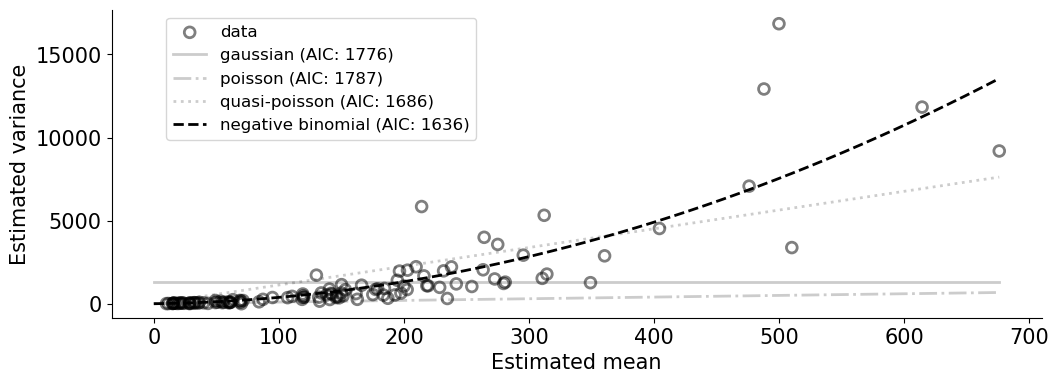


--------------------------------------------------------------------------------------
PERFORMING CALIBRATION OF INFECTIVITY, COMPLIANCE, CONTACT EFFECTIVITY AND SEASONALITY
--------------------------------------------------------------------------------------

Using data from 2020-03-15 until 2021-10-01


1) Particle swarm optimization

Using 18 cores for a population of 180, for maximally 10 iterations.

best after iteration 1: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.993618253733
best after iteration 2: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.993618253733
best after iteration 3: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.993618253733
best after iteration 4: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.993618253733
best after iteration 5: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.993618253733
best after iteration 6: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.993618253733
best after iteration 7: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.993618253733
best after iteration 8: [0.42 0.42 0.55 1.35 1.87 0.18] 3535.9936182537

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/multiprocessing/pool.py", line 692, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/multiprocessing/pool.py", line 672, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/multiprocessing/pool.py", line 692, in _terminate_pool
    cls._help_stuff_finish(inqu

In [10]:
#############################################################
## Compute the overdispersion parameters for our H_in data ##
#############################################################

from covid19model.optimization.utils import variance_analysis
results, ax = variance_analysis(df_hosp['H_in'], resample_frequency='W')
dispersion = results.loc['negative binomial', 'theta']
plt.show()
plt.close()

##########################
## Calibration settings ##
##########################

# PSO settings
processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()/2))
multiplier_pso = 10
maxiter = n_pso
popsize = multiplier_pso*processes
# MCMC settings
multiplier_mcmc = 20
max_n = n_mcmc
print_n = 20
# Define dataset
data=[df_hosp['H_in'][start_calibration:end_calibration], df_sero_herzog['abs','mean'], df_sero_sciensano['abs','mean'][:23]]
states = ["H_in", "R", "R"]
weights = np.array([1, 1, 1]) # Scores of individual contributions: Dataset: 0, total ll: -4590, Dataset: 1, total ll: -4694, Dataset: 2, total ll: -4984
log_likelihood_fnc = [ll_negative_binomial, ll_negative_binomial, ll_negative_binomial]
log_likelihood_fnc_args = [dispersion, dispersion, dispersion]

print('\n--------------------------------------------------------------------------------------')
print('PERFORMING CALIBRATION OF INFECTIVITY, COMPLIANCE, CONTACT EFFECTIVITY AND SEASONALITY')
print('--------------------------------------------------------------------------------------\n')
print('Using data from '+start_calibration.strftime("%Y-%m-%d")+' until '+end_calibration.strftime("%Y-%m-%d")+'\n')

#############################
## Global PSO optimization ##
#############################

# transmission
#pars1 = ['beta',]
#bounds1=((0.001,0.080),)
# Effectivity parameters
pars2 = ['eff_work', 'eff_rest', 'mentality']
bounds2=((0,1),(0,1),(0,1))
# Variants
pars3 = ['K_inf',]
# Must supply the bounds
bounds3 = ((1.00,1.50),(1.50,2.5))
# Seasonality
pars4 = ['amplitude',]
bounds4 = ((0,0.50),)
# Join them together
pars = pars2 + pars3 + pars4
bounds =  bounds2 + bounds3 + bounds4
# Setup prior functions and arguments
log_prior_fnc = len(bounds)*[log_prior_uniform,]
log_prior_fnc_args = bounds

print('\n1) Particle swarm optimization\n')
print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')
sys.stdout.flush()

theta = [0.42, 0.42, 0.55, 1.35, 1.7, 0.18]

####################################
## Local Nelder-mead optimization ##
####################################

# Define objective function
objective_function = log_posterior_probability([],[],model,pars,data,states,
                                               log_likelihood_fnc,log_likelihood_fnc_args,-weights)

from covid19model.optimization import pso, nelder_mead
# Run pso
#theta = pso.optimize(objective_function, bounds, kwargs={'simulation_kwargs':{'warmup': warmup}},
#                   swarmsize=18, maxiter=20, processes=processes, debug=True)[0]
# Run Nelder Mead optimization
#step = len(bounds)*[0.10,]
#theta = nelder_mead.optimize(objective_function, np.array(theta), step, kwargs={'simulation_kwargs':{'warmup': warmup}},
#                            processes=processes, max_iter=20)[0]
                     
###################
## Visualize fit ##
###################

if high_performance_computing:

    print(theta)
    # Assign estimate
    model.parameters = assign_PSO(model.parameters, pars, theta)
    # Perform simulation
    end_visualization = '2022-07-01'
    out = model.sim(end_visualization,start_date=start_calibration, warmup=warmup)
    # Visualize fit
    ax = plot_PSO(out, data, states, start_calibration-pd.Timedelta(days=warmup), end_visualization)
    plt.show()
    plt.close()

    ####################################
    ## Ask the user for manual tweaks ##
    ####################################

    satisfied = not click.confirm('Do you want to make manual tweaks to the calibration result?', default=False)
    while not satisfied:
        # Prompt for input
        new_values = ast.literal_eval(input("Define the changes you'd like to make: "))
        # Modify theta
        for val in new_values:
            theta[val[0]] = float(val[1])
        print(theta)
        # Visualize new fit
        # Assign estimate
        pars_PSO = assign_PSO(model.parameters, pars, theta)
        model.parameters = pars_PSO
        # Perform simulation
        out = model.sim(end_visualization,start_date=start_calibration, warmup=warmup)
        # Visualize fit
        ax = plot_PSO(out, data, states, start_calibration-pd.Timedelta(days=warmup), end_visualization)
        plt.show()
        plt.close()
        # Satisfied?
        satisfied = not click.confirm('Would you like to make further changes?', default=False)

In [ ]:
########################
## Setup MCMC sampler ##
########################

print('\n2) Markov Chain Monte Carlo sampling\n')

# Setup prior functions and arguments
log_prior_fnc = len(bounds)*[log_prior_uniform,]
log_prior_fnc_args = bounds
# Perturbate PSO Estimate
# pars1 = ['beta',]
#pert1 = [0.01,]
# pars2 = ['eff_schools', 'eff_work', 'eff_rest', 'mentality', 'eff_home']
pert2 = [0.10, 0.10, 0.10]
# pars3 = ['K_inf_abc','K_inf_delta']
pert3 = [0.05, 0.05]
# pars4 = ['amplitude']
pert4 = [0.10,] 
# Add them together and perturbate
pert =  pert2 + pert3 + pert4 #+ pert5
ndim, nwalkers, pos = perturbate_PSO(theta, pert, multiplier=multiplier_mcmc, bounds=log_prior_fnc_args, verbose=False)
# Labels for traceplots
labels = ['$\Omega_{work}$', '$\Omega_{rest}$', 'M', '$K_{inf, abc}$', '$K_{inf, delta}$', 'A']
pars_postprocessing = ['eff_work', 'eff_rest', 'mentality', 'K_inf_abc', 'K_inf_delta', 'amplitude']
# Set up the sampler backend if needed
if backend:
    filename = identifier+run_date
    backend = emcee.backends.HDFBackend(backend_folder+filename)
    backend.reset(nwalkers, ndim)
# initialize objective function
objective_function = log_posterior_probability(log_prior_fnc,log_prior_fnc_args,model,pars,data,states,log_likelihood_fnc,log_likelihood_fnc_args,-weights)

In [9]:
theta = [0.42, 0.42, 0.55, 1.35, 1.7, 0.18]
x = np.linspace(0,1.5,10)
y=[]
for i,val in enumerate(x):
    theta[0] = val
    y.append(objective_function(theta, simulation_kwargs={'warmup':warmup}))

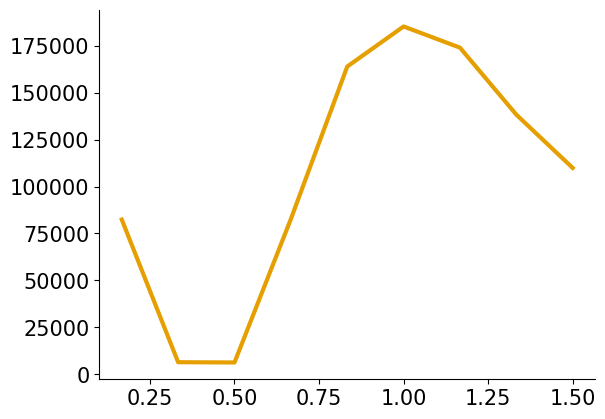

In [10]:
# Make a meshed grid
fig,ax=plt.subplots()
ax.plot(x,y)
ax.grid(False)

In [93]:
######################
## Run MCMC sampler ##
######################

# Derive nwalkers, ndim from shape of pos
nwalkers, ndim = pos.shape
# Setup sampler without multiprocessing
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_function, backend=None,
                        args=(), kwargs={'simulation_kwargs': {'warmup': warmup}},
                        moves=[(emcee.moves.DEMove(), 0.5),(emcee.moves.KDEMove(bw_method='scott'), 0.5)])
# Start mcmc
for sample in sampler.sample(pos, iterations=max_n, progress=True, store=True, tune=True):
    if sampler.iteration % print_n:
                continue

/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-3297.1345569162295
-3407.557182916801
-3725.3849420683673


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-6711.142395337149
-6815.895233602973
-7171.201571381649


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-4337.42148248267
-4451.926227217959
-4771.3108513464085


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-5697.650371779899
-5805.221754269628
-6176.404540858404


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-3810.027613999766
-3926.6408890329303
-4277.367441643435


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-5257.8434456930045
-5362.098695354141
-5711.284257492805


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-6029.620797889751
-6167.1957721553745
-6526.591508198935


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/xarray/core/missi

-3657.737023565547
-3780.551835052972
-4113.227009472959
emcee: Exception while calling your likelihood function:
  params: [0.3998084  0.45954269 0.59409857 1.38533526 1.66944911 0.18205715]
  args: []
  kwargs: {'simulation_kwargs': {'warmup': 39}}
  exception:


Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/optimization/objective_fcns.py", line 523, in __call__
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/base.py", line 650, in sim
    output.append(self._mp_sim_single(dictionary, time, actual_start_date, method=method, rtol=rtol, l=l))
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/base.py", line 507, in _mp_sim_single
    out = self._sim_single(time, actual_start_date, method, rtol, l)
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/base.py", line 474, in _sim_single
    output = solve_ivp(fun, time, y0, args=[self.parameters], t_eval=t_eval, met

# Spatial model



spatially-weighted overdispersion: 0.03582586474901687

--------------------------------------------------------------------------------------
PERFORMING CALIBRATION OF INFECTIVITY, COMPLIANCE, CONTACT EFFECTIVITY AND SEASONALITY
--------------------------------------------------------------------------------------

Using data from 2020-03-15 until 2021-10-01


1) Particle swarm optimization

Using 18 cores for a population of 54, for maximally 10 iterations.

[0.0225, 0.0225, 0.0255, 0.5, 0.65, 0.522, 1.35, 1.45, 0.24]


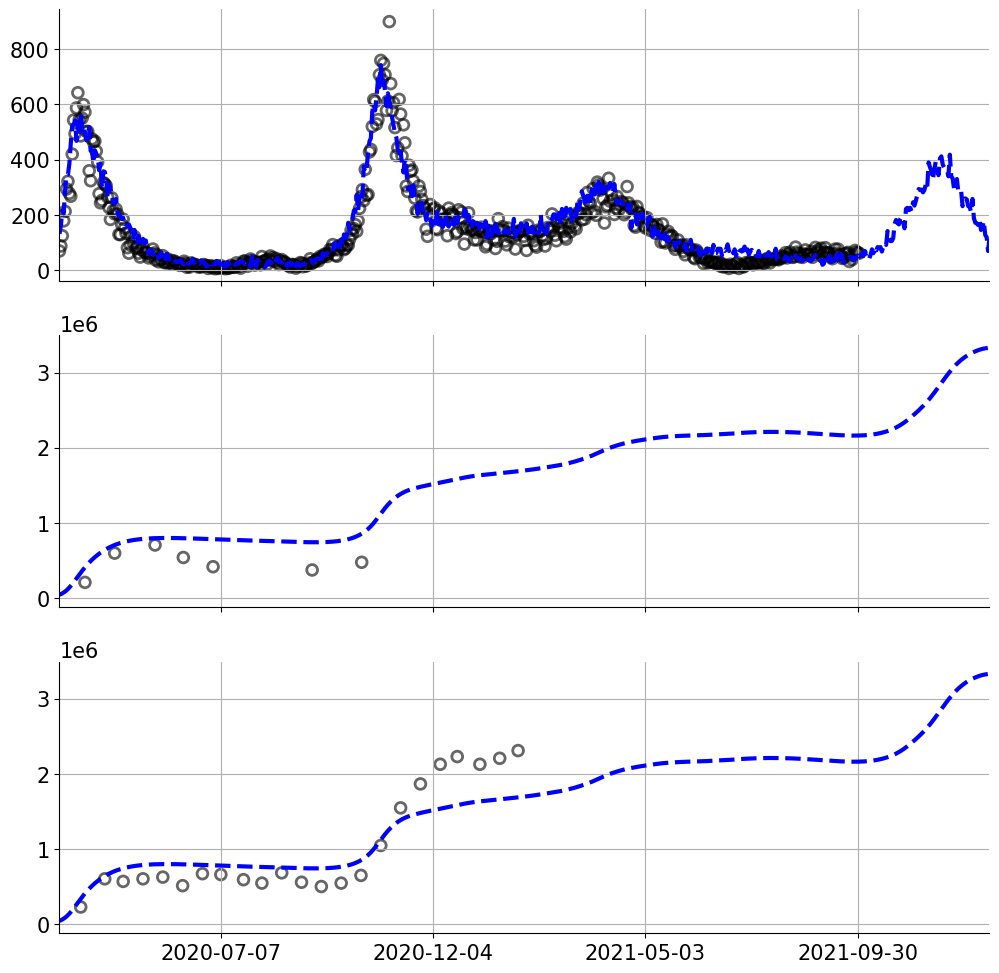

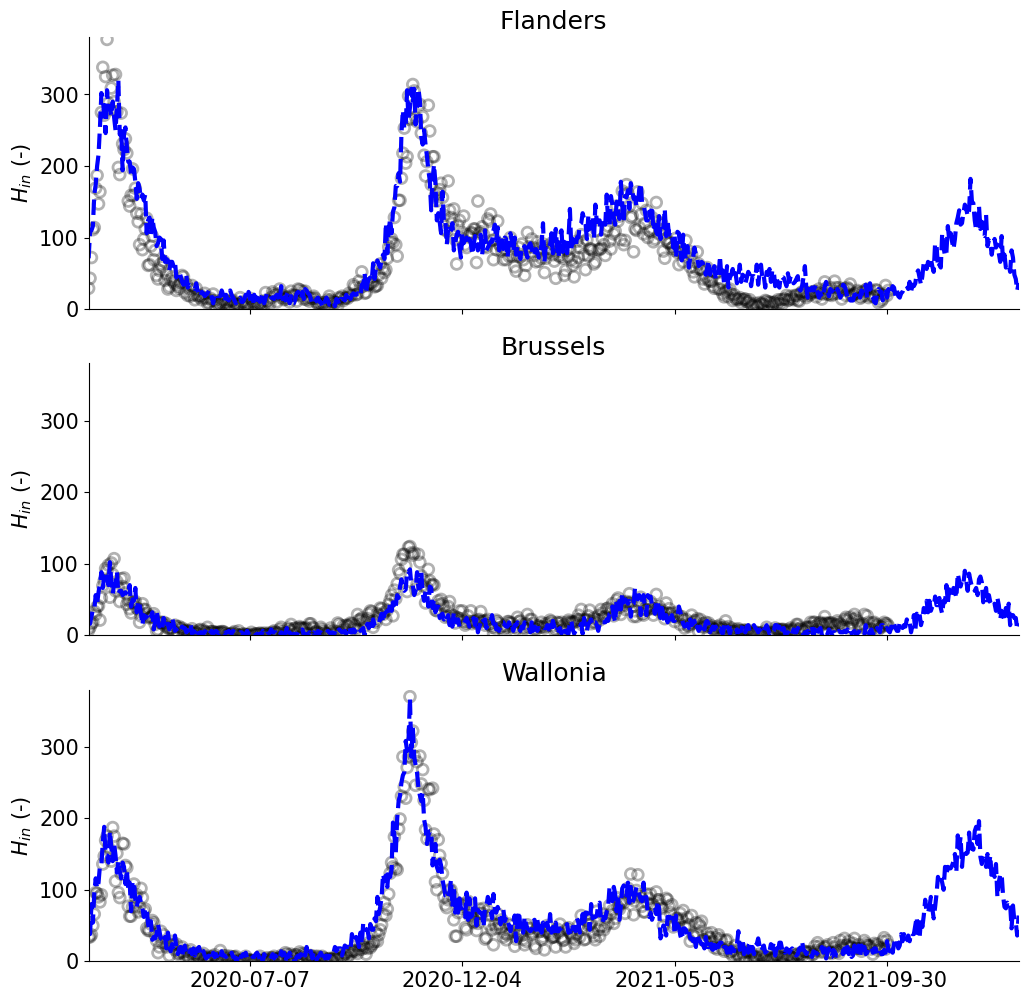

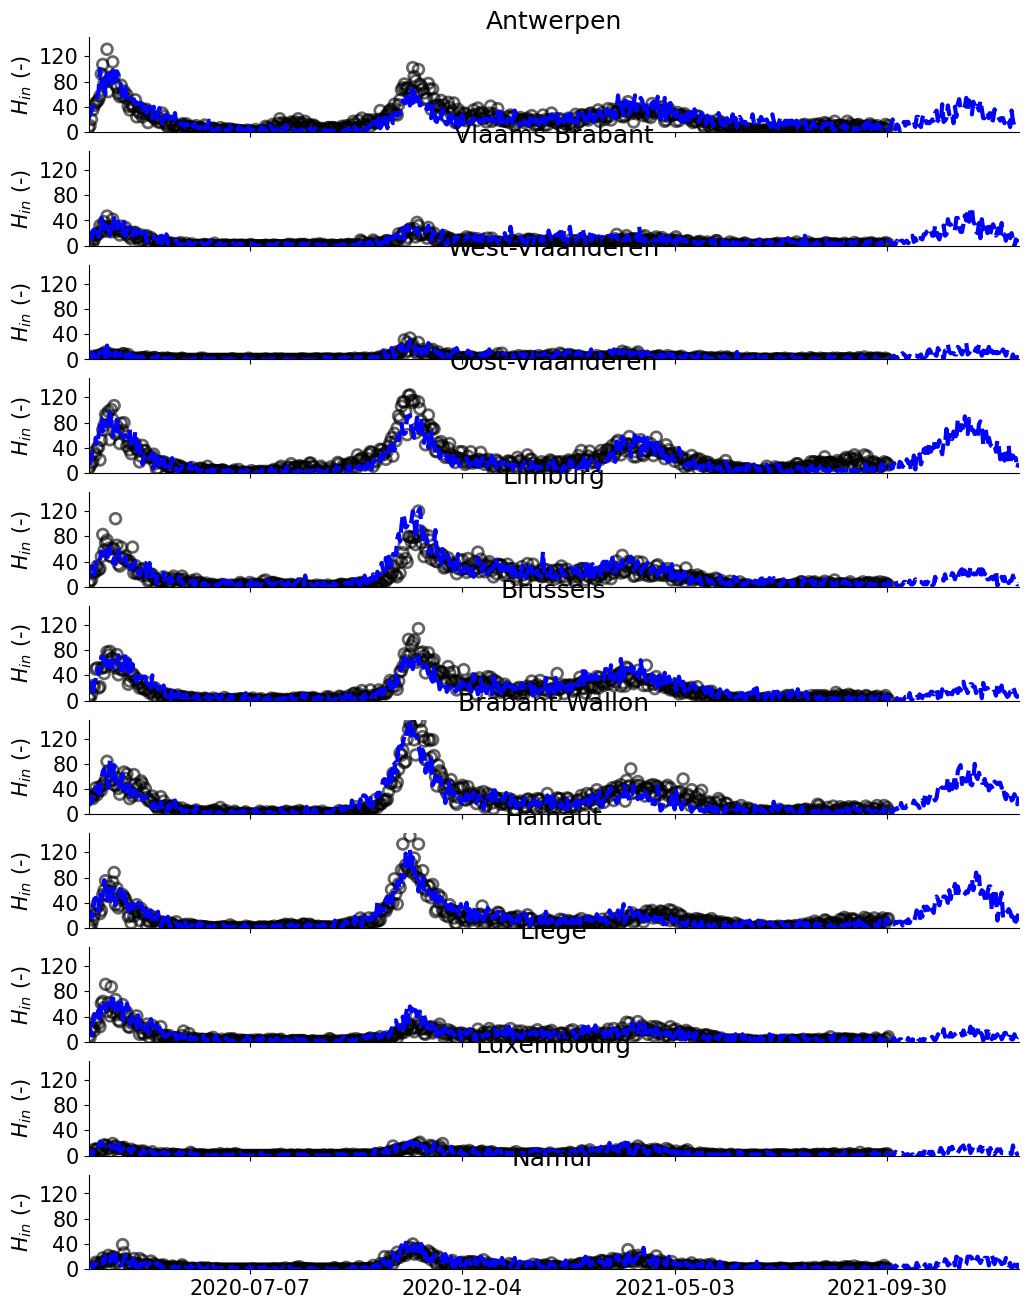

Do you want to make manual tweaks to the calibration result? [y/N]: N

PSO RESULTS:
------------
infectivities ['beta_R', 'beta_U', 'beta_M']: [0.0225, 0.0225, 0.0255].
effectivity parameters ['eff_work', 'eff_rest', 'mentality', 'K_inf', 'amplitude']: [0.5, 0.65, 0.522, 1.35, 1.45].
VOC effects []: [0.24].
Seasonality []: []


In [3]:
"""
This script contains a calibration of the spatial COVID-19 SEIQRD model to hospitalization data in Belgium during the period 2020-03-15 until 2021-10-07.
"""

__author__      = " Tijs W. Alleman, Michiel Rollier"
__copyright__   = "Copyright (c) 2022 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved."

############################
## Load required packages ##
############################

# Numpy has this weird glitch, deep down, where, if the number of 'reads' it has to perform becomes too large, it starts to use multiprocessing and this results in quadratic CPU usage (very undesirable)
# The following line of code prevents this from happening
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Load standard packages
import ast
import click
import sys
import datetime
import argparse
import pandas as pd
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
# Import the function to initialize the model
from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc
# Import packages containing functions to load in necessary data
from covid19model.data import sciensano
# Import function associated with the PSO and MCMC
from covid19model.optimization.nelder_mead import nelder_mead
from covid19model.optimization.objective_fcns import log_prior_uniform, ll_poisson, ll_negative_binomial, log_posterior_probability
from covid19model.optimization.pso import *
from covid19model.optimization.utils import perturbate_PSO, run_MCMC, assign_PSO
from covid19model.visualization.optimization import plot_PSO, plot_PSO_spatial

####################################
## Public or private spatial data ##
####################################

public = True

#############################
## Handle script arguments ##
#############################

identifier = 'tryout_automatic_alignment'
n_pso = 10
n_mcmc = 10
n_age_groups = 10
age_stratification_size=n_age_groups
start_calibration = pd.to_datetime('2020-03-15')
end_calibration = pd.to_datetime('2021-10-01')
high_performance_computing=True
backend=None
run_date = str(datetime.date.today())
agg='prov'

##############################
## Define results locations ##
##############################

# Path where traceplot and autocorrelation figures should be stored.
# This directory is split up further into autocorrelation, traceplots
fig_path = f'../../results/calibrations/COVID19_SEIQRD/{agg}/'
# Path where MCMC samples should be saved
samples_path = f'../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/{agg}/'
# Path where samples backend should be stored
backend_folder = f'../../results/calibrations/COVID19_SEIQRD/{agg}/backends/'
# Verify that the paths exist and if not, generate them
for directory in [fig_path, samples_path, backend_folder]:
    if not os.path.exists(directory):
        os.makedirs(directory)
# Verify that the fig_path subdirectories used in the code exist
for directory in [fig_path+"autocorrelation/", fig_path+"traceplots/", fig_path+"pso/"]:
    if not os.path.exists(directory):
        os.makedirs(directory)

##################################################
## Load data not needed to initialize the model ##
##################################################

# Raw local hospitalisation data used in the calibration. Moving average disabled for calibration. Using public data if public==True.
if agg == 'prov':
    df_hosp = sciensano.get_sciensano_COVID19_data(update=False)[0]['H_in']
elif agg == 'arr':
    df_hosp = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=False)['hospitalised_IN']
# Set end of calibration to last datapoint if no enddate is provided by user
if not end_calibration:
    end_calibration = df_hosp.index.get_level_values('date').max()
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size, agg=agg,
                                                                                    start_date=start_calibration.strftime("%Y-%m-%d"), stochastic=True)

if __name__ == '__main__':

    #############################################################
    ## Compute the overdispersion parameters for our H_in data ##
    #############################################################

    from covid19model.optimization.utils import variance_analysis
    results, ax = variance_analysis(df_hosp.loc[(slice(start_calibration, end_calibration), slice(None))], 'W')
    dispersion_weighted = sum(np.array(results.loc[(slice(None), 'negative binomial'), 'theta'])*initN.sum(axis=1).values)/sum(initN.sum(axis=1).values)
    #print(results)
    print('\n')
    print('spatially-weighted overdispersion: ' + str(dispersion_weighted))
    #plt.show()
    plt.close()

    ##########################
    ## Calibration settings ##
    ##########################

    # PSO settings
    processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()/2))
    multiplier_pso = 3
    maxiter = n_pso
    popsize = multiplier_pso*processes
    # MCMC settings
    multiplier_mcmc = 10
    max_n = n_mcmc
    print_n = 5
    # Define dataset
    data=[df_hosp.loc[(slice(start_calibration,end_calibration), slice(None))], df_sero_herzog['abs','mean'], df_sero_sciensano['abs','mean'][:23]]
    states = ["H_in", "R", "R"]
    weights = np.array([1, 1, 1]) # Scores of individual contributions: 1) 17055, 2+3) 255 860, 3) 175571
    log_likelihood_fnc = [ll_negative_binomial, ll_negative_binomial, ll_negative_binomial]
    log_likelihood_fnc_args = [results.loc[(slice(None), 'negative binomial'), 'theta'].values, dispersion_weighted, dispersion_weighted] 
    #log_likelihood_fnc_args = [[], dispersion_weighted, dispersion_weighted]
    
    print('\n--------------------------------------------------------------------------------------')
    print('PERFORMING CALIBRATION OF INFECTIVITY, COMPLIANCE, CONTACT EFFECTIVITY AND SEASONALITY')
    print('--------------------------------------------------------------------------------------\n')
    print('Using data from '+start_calibration.strftime("%Y-%m-%d")+' until '+end_calibration.strftime("%Y-%m-%d")+'\n')
    print('\n1) Particle swarm optimization\n')
    print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')
    sys.stdout.flush()

    #############################
    ## Global PSO optimization ##
    #############################

    # transmission
    pars1 = ['beta_R', 'beta_U', 'beta_M']
    bounds1=((0.01,0.070),(0.01,0.070),(0.01,0.070))
    # Social intertia
    # Effectivity parameters
    pars2 = ['eff_work', 'eff_rest', 'mentality']
    bounds2=((0,0.80),(0,1),(0,1))
    # Variants
    pars3 = ['K_inf',]
    bounds3 = ((1.20, 1.60),(1.50,2.20))
    # Seasonality
    pars4 = ['amplitude',]
    bounds4 = ((0,0.40),)
    # Join them together
    pars = pars1 + pars2 + pars3 + pars4  
    bounds = bounds1 + bounds2 + bounds3 + bounds4
    # Setup objective function without priors and with negative weights 
    #objective_function = log_posterior_probability([],[],model,pars,data,states,log_likelihood_fnc,log_likelihood_fnc_args,-weights)
    # Perform pso
    #theta, obj_fun_val, pars_final_swarm, obj_fun_val_final_swarm = optim(objective_function, bounds, args=(), kwargs={},
    #                                                                        swarmsize=popsize, maxiter=maxiter, processes=processes, debug=True)

    theta =  [0.0225, 0.0225, 0.0255, 0.5, 0.65, 0.522, 1.35, 1.45, 0.24] # --> prov stochastic
    #theta = [0.0229, 0.0229, 0.0255, 0.49, 0.589, 0.593, 1.3, 1.63, 0.22] # first try --> prov stochstic
    l=1/2

    ####################################
    ## Local Nelder-mead optimization ##
    ####################################
    
    # Define objective function
    objective_function = log_posterior_probability([],[],model,pars,data,states,log_likelihood_fnc,log_likelihood_fnc_args,-weights)
    # Run Nelder Mead optimization
    #step = len(bounds)*[0.05,]
    #sol = nelder_mead(objective_function, np.array(theta), step, (), processes=processes)

    #######################################
    ## Visualize fits on multiple levels ##
    #######################################

    if high_performance_computing:
        # Assign estimate.
        print(theta)
        pars_PSO = assign_PSO(model.parameters, pars, theta)
        model.parameters = pars_PSO
        end_visualization = '2022-01-01'
        # Perform simulation with best-fit results
        out = model.sim(end_visualization,start_date=start_calibration, l=l)
        # National fit
        data_star=[data[0].groupby(by=['date']).sum(), df_sero_herzog['abs','mean'], df_sero_sciensano['abs','mean'][:23]]
        ax = plot_PSO(out, data_star, states, start_calibration, end_visualization)
        plt.show()
        plt.close()
        # Regional fit
        ax = plot_PSO_spatial(out, data[0], start_calibration, end_visualization, agg=agg, desired_agg='reg')
        plt.show()
        plt.close()
        # Provincial fit
        ax = plot_PSO_spatial(out, data[0], start_calibration, end_visualization, agg=agg, desired_agg='prov')
        plt.show() 
        plt.close()

        ####################################
        ## Ask the user for manual tweaks ##
        ####################################

        satisfied = not click.confirm('Do you want to make manual tweaks to the calibration result?', default=False)
        while not satisfied:
            # Prompt for input
            new_values = ast.literal_eval(input("Define the changes you'd like to make: "))
            # Modify theta
            for val in new_values:
                theta[val[0]] = float(val[1])
            print(theta)
            # Assign estimate
            pars_PSO = assign_PSO(model.parameters, pars, theta)
            model.parameters = pars_PSO
            # Perform simulation
            out = model.sim(end_visualization,start_date=start_calibration, l=l)
            # Visualize national fit
            ax = plot_PSO(out, data_star, states, start_calibration, end_visualization)
            plt.show()
            plt.close()
            # Visualize regional fit
            ax = plot_PSO_spatial(out, data[0], start_calibration, end_visualization, agg=agg, desired_agg='reg')
            plt.show()
            plt.close()
            # Visualize provincial fit
            ax = plot_PSO_spatial(out, data[0], start_calibration, end_visualization, agg=agg, desired_agg='prov')
            plt.show()
            plt.close()
            # Satisfied?
            satisfied = not click.confirm('Would you like to make further changes?', default=False)

    # Print statement to stdout once
    print(f'\nPSO RESULTS:')
    print(f'------------')
    print(f'infectivities {pars[0:3]}: {theta[0:3]}.')
    print(f'effectivity parameters {pars[3:8]}: {theta[3:8]}.')
    print(f'VOC effects {pars[8:9]}: {theta[8:10]}.')
    print(f'Seasonality {pars[9:10]}: {theta[10:11]}')
    #print(f'Waning antibodies {pars[10:]}: {theta[11]}')
    sys.stdout.flush()

In [4]:
########################
## Setup MCMC sampler ##
########################

print('\n2) Markov Chain Monte Carlo sampling\n')

# Setup prior functions and arguments
log_prior_fnc = len(bounds)*[log_prior_uniform,]
log_prior_fnc_args = bounds
# Perturbate PSO estimate by a certain maximal *fraction* in order to start every chain with a different initial condition
# Generally, the less certain we are of a value, the higher the perturbation fraction
# pars1 = ['beta_R', 'beta_U', 'beta_M']
pert1=[0.02, 0.02, 0.02]
# pars2 = ['eff_work', 'eff_rest', 'mentality']
pert2=[0.20, 0.20, 0.20]
# pars3 = ['K_inf_abc', 'K_inf_delta']
pert3 = [0.10, 0.10]
# pars4 = ['amplitude']
pert4 = [0.20,] 
# Add them together
pert = pert1 + pert2 + pert3 + pert4
# Labels for traceplots
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$', \
            '$\\Omega_{work}$', '$\\Omega_{rest}$', 'M', \
            '$K_{inf, abc}$', '$K_{inf, delta}$', \
            '$A$']
pars_postprocessing = ['beta_R', 'beta_U', 'beta_M', 'eff_work', 'eff_rest', 'mentality', 'K_inf_abc', 'K_inf_delta', 'amplitude']
# Use perturbation function
ndim, nwalkers, pos = perturbate_PSO(theta, pert, multiplier=multiplier_mcmc, bounds=log_prior_fnc_args, verbose=False)
# Set up the sampler backend if needed
if backend:
    import emcee
    filename = f'{identifier}_backend_{run_date}'
    backend = emcee.backends.HDFBackend(samples_path+filename)
    backend.reset(nwalkers, ndim)
# initialize objective function
objective_function = log_posterior_probability(log_prior_fnc,log_prior_fnc_args,model,pars,data,states,log_likelihood_fnc,log_likelihood_fnc_args,weights)


2) Markov Chain Monte Carlo sampling



In [7]:
######################
## Run MCMC sampler ##
######################
processes=1

# Derive nwalkers, ndim from shape of pos
nwalkers, ndim = pos.shape
# Setup sampler without multiprocessing
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_function, backend=None,
                        args=(), kwargs={'simulation_kwargs': {'warmup': 0}},
                        moves=[(emcee.moves.DEMove(), 0.5),(emcee.moves.KDEMove(bw_method='scott'), 0.5)])
# Start mcmc
for sample in sampler.sample(pos, iterations=max_n, progress=True, store=True, tune=True):
    if sampler.iteration % print_n:
                continue

emcee: Exception while calling your likelihood function:
  params: [0.02273912 0.02216982 0.02578123 0.51893985 0.66666172 0.49692648
 1.40043668 1.67354286 0.2551422 ]
  args: []
  kwargs: {'simulation_kwargs': {'warmup': 0}}
  exception:


Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/optimization/objective_fcns.py", line 495, in __call__
    out = self.model.sim(self.end_sim, start_date=self.start_sim, **simulation_kwargs)
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/base.py", line 650, in sim
    output.append(self._mp_sim_single(dictionary, time, actual_start_date, method=method, rtol=rtol, l=l))
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/base.py", line 507, in _mp_sim_single
    out = self._sim_single(time, actual_start_date, method, rtol, l)
  File "/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/base.py", line 476, in _sim_